### Simple MCMC 

In [1]:
import numpy as np
import math
import random as r
import pylab
import matplotlib.pyplot as plt
from numba import jit

## Sign function
sign = lambda x : math.copysign(1,x)
N = 10
N2 = N**2


In [2]:
@jit(nopython=True)
def CEnergy(latt, N):
    Ene = 0
    for i in range(N):
        for j in range(N):
            S = latt[i,j]
            WF = latt[i, (j+1)%N] + latt[i, (j-1)%N] + latt[(i+1)%N, j] + latt[(i-1)%N, j]
            Ene += -S*WF
    return int(Ene/2.)

def RandomL(N):
    latt = np.zeros((N,N), dtype=int)
    for i in range(N):
        for j in range(N):
            latt[i,j] = sign(2*r.random() - 1)
    return latt

In [3]:
def MCMC(Nitt, N, T):
    Aven = 0.0
    latt = RandomL(N)
    print(f"lattice: {latt}")
    Ene = CEnergy(latt, N)
    Emin = -2 * N * N
    density = np.zeros(N*N+1, dtype=int).tolist()
    for i in range(Nitt):
        # ii = int(r.random()*100)
        i = int(r.random() * N)
        j = int(r.random() * N)
        S = latt[i,j]
        WF = latt[i, (j+1)%N] + latt[i, (j-1)%N] + latt[(i+1)%N, j] + latt[(i-1)%N, j]
        Enew = Ene + 2*S*WF
        P = min(1, math.exp((Ene-Enew)/T))
        if P > r.random(): #metropolis condition
            latt[i,j] = -S #flip the state of lattice
            Ene = Enew #update energy
        index = (Ene - Emin) // 4
        density[index] += 1 #update density of states
        Aven += Ene
    return (density, Aven/Nitt) # return the dos and avg energy for the given temperature

Energies = (4*np.arange(N2+1)-2*N2).tolist()


lattice: [[-1 -1 -1  1  1  1  1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1  1  1  1]
 [ 1  1 -1 -1  1  1  1 -1  1  1]
 [-1 -1 -1 -1 -1  1 -1 -1  1 -1]
 [-1 -1  1  1  1 -1  1 -1 -1 -1]
 [ 1  1  1  1 -1 -1  1  1  1 -1]
 [-1  1  1  1 -1  1  1  1  1  1]
 [-1  1  1  1  1 -1 -1  1 -1 -1]
 [ 1 -1 -1 -1  1 -1 -1  1  1 -1]
 [ 1  1  1 -1 -1  1 -1  1 -1  1]]


<Figure size 800x600 with 0 Axes>

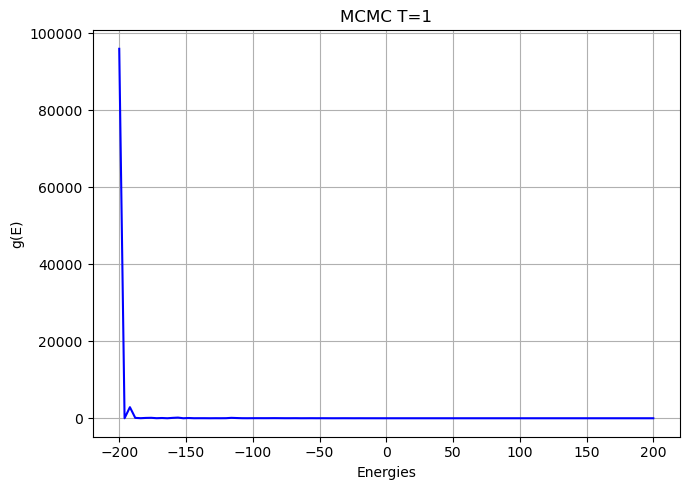

lattice: [[ 1  1 -1 -1 -1 -1 -1  1 -1 -1]
 [-1 -1  1  1 -1 -1 -1  1  1 -1]
 [-1 -1 -1  1 -1  1  1  1  1 -1]
 [-1 -1  1 -1 -1  1  1 -1  1  1]
 [ 1 -1 -1 -1  1 -1  1  1 -1 -1]
 [-1 -1 -1  1  1 -1  1 -1 -1  1]
 [ 1 -1  1  1  1  1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1 -1  1  1  1 -1]
 [-1 -1 -1 -1  1 -1 -1 -1  1  1]
 [-1 -1 -1  1  1 -1 -1 -1  1 -1]]


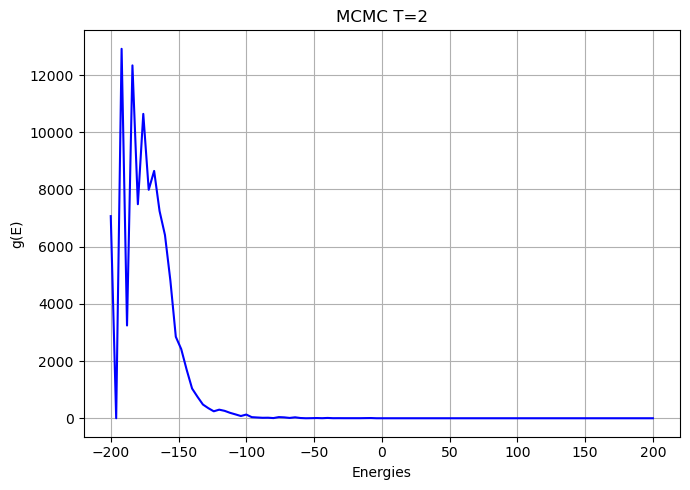

lattice: [[ 1  1  1 -1  1  1  1 -1  1 -1]
 [ 1  1 -1 -1  1 -1  1  1 -1 -1]
 [ 1 -1 -1 -1  1  1  1  1  1  1]
 [ 1 -1 -1 -1 -1  1 -1 -1  1 -1]
 [ 1 -1 -1  1  1  1  1  1  1  1]
 [ 1 -1  1 -1  1  1  1  1  1 -1]
 [ 1 -1  1  1  1  1  1 -1  1 -1]
 [-1  1  1 -1  1  1 -1 -1  1 -1]
 [-1  1  1 -1 -1  1 -1  1  1  1]
 [-1 -1  1  1 -1 -1  1 -1  1  1]]


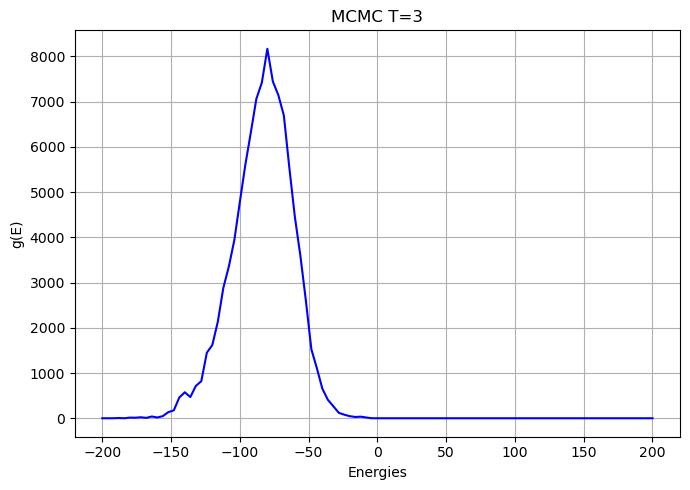

lattice: [[-1  1  1 -1  1  1 -1  1 -1  1]
 [ 1  1 -1 -1  1  1 -1 -1 -1  1]
 [ 1 -1  1  1 -1  1 -1  1  1 -1]
 [ 1  1  1 -1 -1 -1  1  1  1 -1]
 [ 1 -1  1 -1 -1 -1  1  1  1  1]
 [ 1  1 -1 -1 -1  1 -1  1 -1  1]
 [-1 -1 -1 -1  1 -1  1  1  1 -1]
 [ 1 -1 -1  1 -1  1  1  1 -1  1]
 [-1  1  1  1 -1 -1  1  1 -1  1]
 [ 1  1  1 -1  1  1 -1 -1 -1  1]]


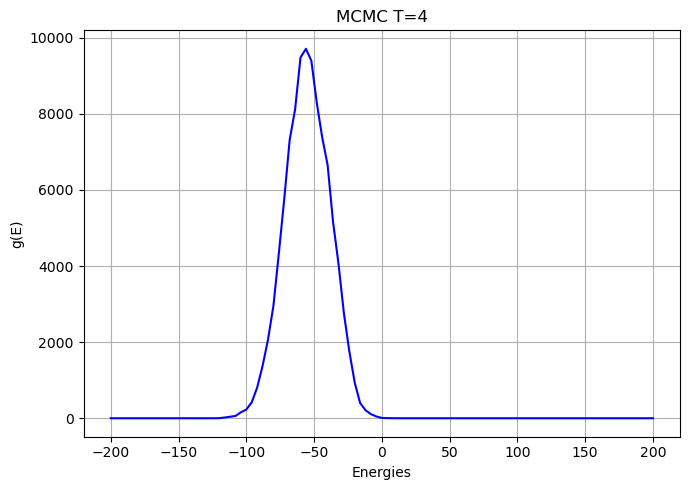

lattice: [[-1  1  1  1 -1 -1  1  1  1  1]
 [-1 -1  1 -1  1  1 -1  1 -1 -1]
 [ 1  1 -1  1  1 -1 -1  1 -1 -1]
 [ 1 -1 -1  1  1 -1 -1 -1  1  1]
 [-1  1 -1 -1 -1  1  1 -1  1  1]
 [-1 -1 -1 -1  1  1 -1  1 -1 -1]
 [-1 -1  1 -1 -1  1 -1  1 -1  1]
 [ 1  1 -1  1  1 -1 -1  1 -1 -1]
 [-1 -1 -1 -1 -1  1 -1  1  1  1]
 [ 1  1 -1 -1 -1 -1 -1  1  1 -1]]


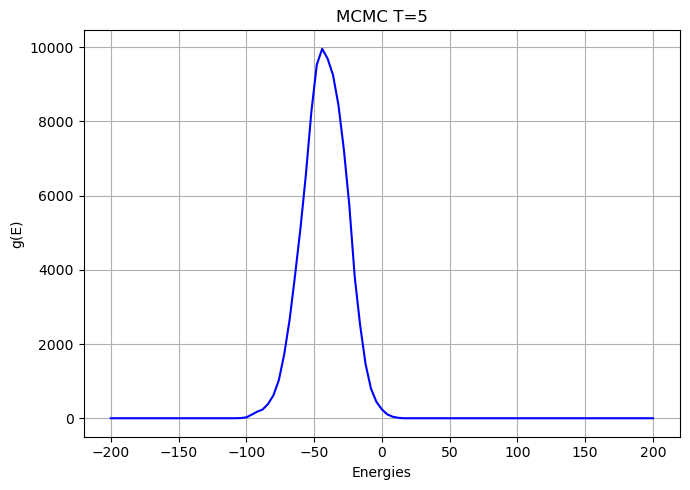

lattice: [[-1 -1 -1  1  1 -1  1 -1 -1  1]
 [ 1 -1  1 -1 -1  1 -1 -1  1  1]
 [-1 -1  1 -1  1 -1  1 -1 -1 -1]
 [-1  1 -1  1  1 -1 -1  1  1  1]
 [-1 -1  1  1 -1  1 -1 -1 -1  1]
 [ 1 -1  1 -1 -1 -1  1  1 -1 -1]
 [ 1  1 -1 -1 -1 -1  1  1  1 -1]
 [ 1 -1  1  1  1  1  1  1 -1 -1]
 [ 1 -1  1 -1 -1  1  1  1  1  1]
 [ 1 -1  1 -1  1 -1 -1  1 -1  1]]


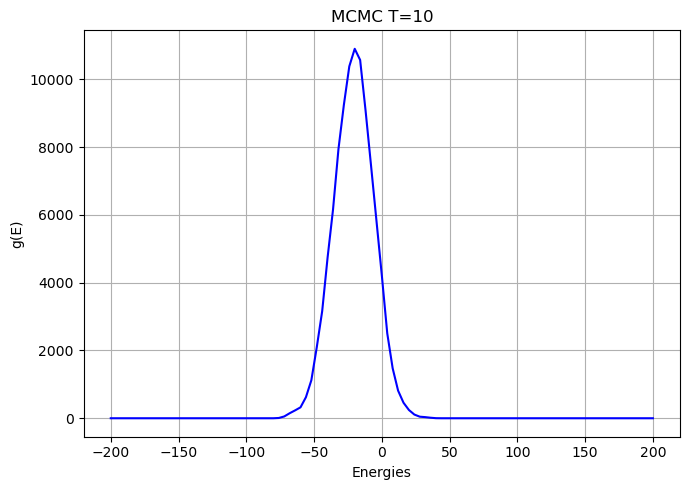

lattice: [[ 1  1 -1  1  1 -1  1  1 -1  1]
 [ 1  1  1 -1 -1 -1 -1  1 -1  1]
 [-1 -1 -1  1 -1 -1 -1 -1  1 -1]
 [-1  1 -1 -1  1 -1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1  1  1 -1 -1  1]
 [-1  1 -1  1  1  1  1  1 -1 -1]
 [-1 -1 -1  1  1 -1  1 -1  1  1]
 [ 1  1 -1 -1 -1 -1  1  1  1 -1]
 [-1  1  1  1  1 -1  1 -1 -1  1]
 [-1 -1  1 -1 -1  1  1 -1 -1 -1]]


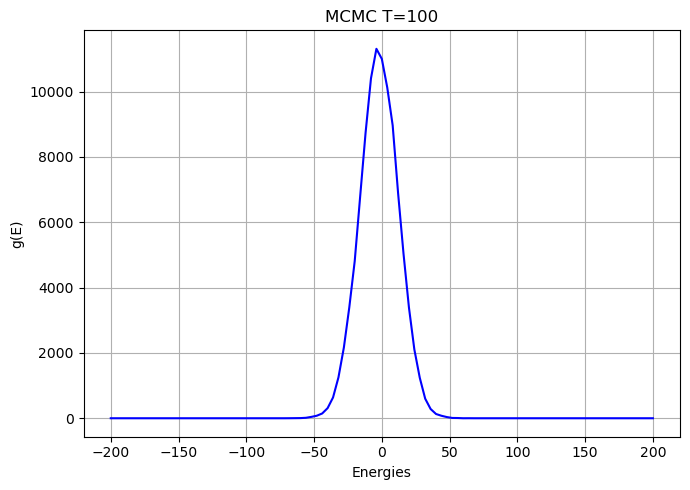

In [4]:
Nitt = int(1e5)
temps = [1, 2, 3, 4, 5, 10, 100]
plt.figure(figsize=(8,6))
for idx, T in enumerate(temps):
    density, avg_E  = MCMC(Nitt, N, T)
    plt.figure(figsize=(7,5))
    plt.plot(Energies , density, 'b')
    plt.xlabel('Energies')
    plt.ylabel('g(E)')
    plt.title(f'MCMC T={T}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### Multilpe Histogram Reweighting
#### Reference: 'Optimized Monte Carlo data analysis', A. M. Ferrenberg and R. H. Swendsen, Physical Review Letters 63, 1195 (1989).


In [5]:
import numpy as np

def free_energies(b, X, nmaxit=20, weights=None, argoffset=True):

    r"""
    General function to calculate the relative free energies for MHR

    General function to calculate the relative free energies :math:`F^{(1)},F^{(2)}\dotsc` 
    for MHR from simulation data -- see the module-level documentation for definitions. 
    An iterative procedure is used to solve the relevant equation.

    Arguments:
        b (2 dimensional array): Values of :math:`\mathbf{b}^{(n)}`. `b[n]` is :math:`\mathbf{b}^{(n)}`.
          `b[n][i]` is the `i` th displacement for :math:`\mathbf{b}^{(n)}`.
        X (list of 3-dimensional arrays): Generalised displacements data for various :math:`\mathbf{b}^{(n)}`.
          `X[n]` is the data pertaining to :math:`\mathbf{b}^{(n)}`, and is an array. `X[n][i,k]` is the 
          `k` th generalised displacement for the `i` th data point in the data pertaining to 
          :math:`\mathbf{b}^{(n)}`.
        nmaxit (int) : Number of iterations to perform to solve the equation.
        weights (list of arrays): Weights to be applied to each data point in `X`;
          The `i` th data point pertaining to :math:`\mathbf{b}^{(n)}` will be counted `weight[n][i]` 
          times. If `None` then all data points are counted once.
        argoffset (bool) : If True then a constant is added to the arguments to the exponential functions in
          the equation given above for evaluating :math:`F^{(1)},F^{(2)}\dotsc` in order to prevent overflows
          and underflows (as much as is possible). This constant, which was denoted :math:`D` in the equation, is set to
          the negative of the mean value of :math:`\mathbf{b}^{(n)}\cdot\mathbf{X}_{pi}` over all :math:`n`,
          :math:`p` and :math:`i`. If False then the behaviour is equivalent to setting :math:`D=0`.

    Returns:
        array: Free energies :math:`F^{(1)},F^{(2)},\dotsc` corresponding to :math:`\mathbf{b}^{(1)},\mathbf{b}^{(1)},\dotsc`. 
        Equivalently, `F[n]` is the free energy corresopnding to `b[n]`

    """

    # Relevant equation:
    # \exp(-F^{(n)}) = \sum_{p=1}^{R}\sum_{i=1}^{N_p}\frac{ \exp(\mathbf{b}^{(n)}\cdot\mathbf{X}_{pi}+D) }{\sum_{q=1}^{R}\exp(\mathbf{b}^{(q)}\cdot\mathbf{X}_{pi}+F^{(q)}+D)N_q}
    
    nrun = len(b)        
    assert len(X) == nrun, "Check 'b' and 'X' have matching lengths"
                      
    # Free energies for each data set
    fold = np.ones(nrun)
    f = np.zeros(nrun)

    # Number of data points in each data set
    ndata = np.zeros(nrun, dtype = 'int')
    for irun1 in range(nrun):
        ndata[irun1] = X[irun1].shape[0]

    # Determine 'D' if needed
    D = 0.0
    Dcount = 0 
    if argoffset:
        for irun1 in range(nrun):
            for irun2 in range(nrun):
                for idata in range(ndata[irun2]):
                    D += np.dot(b[irun1,:],X[irun2][idata,:])
                    Dcount += 1
        D = - D / Dcount
       
        
    for n in range(nmaxit):
        
        # Begin iteration
        for i in range(nrun):
            f[i] = 0.0
        
            # f = free_energy(...)
            for irun1 in range(nrun):
                for idata in range(ndata[irun1]):
                    # Accumulate the denominator
                    sum = 0.0
                    for irun2 in range(nrun):
                        arg = np.dot(b[irun2,:],X[irun1][idata,:]) + fold[irun2] + D
                        sum += 1.0*ndata[irun2]*np.exp(arg)

                    # 'sum' now the denominator in the equation given above
                    # Calculate the numerator and add the term to the sum
                    arg = np.dot(b[irun1,:],X[irun1][idata,:]) + D
                    if weights == None:
                        f[i] += (1.0/sum)*np.exp(arg)
                    else:
                        f[i] += (weights[irun1][idata]/sum)*np.exp(arg)

        #TU: 'f' is now the RHS of (1)
        fold[:] = -np.log(f[:])

        #TU: 'fold' is now f_n in (1)

        #TU: Shift the free energies at the end of each iteration so 
        #    that they are as close as possible to 0; to prevent
        #    overflows and underflows
        fold = fold - fold.min()
        
    return fold




def reweight_observable(b, X, obs, bnew, fe=None, weights=None, argoffset=True):

    r"""
    General function to reweight an observable using MHR.

    General function to reweight an observable using MHR. See the module-level documentation for
    definitions of the ensemble.

    Arguments:
        b (2 dimensional array): Values of :math:`\mathbf{b}^{(n)}`. `b[n]` is :math:`\mathbf{b}^{(n)}`.
          `b[n][i]` is the `i` th displacement for :math:`\mathbf{b}^{(n)}`.
        X (list of 3-dimensional arrays): Generalised displacements data for various :math:`\mathbf{b}^{(n)}`.
          `X[n]` is the data pertaining to :math:`\mathbf{b}^{(n)}`, and is an array. `X[n][i][k]` is the 
          `k` th generalised displacement for the `i` th data point in the data pertaining to 
          :math:`\mathbf{b}^{(n)}`.
        obs (list of 2-dimensional arrays): Values of the observables: `obs[n][i]` is the observable
           corresponding to the `i` th data point at :math:`\mathbf{b}^{(n)}`, i.e. :math:`O_{ni}`
        bnew (array): The set of generalised displacements, :math:`\mathbf{b}'`, to be reweighted to.
           `bnew[i]` is the `i` th displacement for :math:`\mathbf{b}'`
        fe (array) (optional): Free energies :math:`F^{(1)},F^{(2)},\dotsc` corresponding to 
          :math:`\mathbf{b}^{(1)},\mathbf{b}^{(1)},\dotsc`; `F[n]` is the free energy corresopnding 
          to `b[n]`. If this is absent then it is calculated using the `free energies` function
        weights (list of arrays): Weights to be applied to each data point in `X`;
          The `i` th data point pertaining to :math:`\mathbf{b}^{(n)}` will be counted `weight[n][i]` 
          times. If `None` then all data points are counted once.
        argoffset (bool) : If True then a constant is added to the arguments to the exponential functions in
          the equation given above for evaluating :math:`\langle O'\rangle` in order to prevent overflows
          and underflows (as much as is possible). This constant, which was denoted :math:`C` in the equation, is set to
          the negative of the mean value of :math:`(\mathbf{b}'-\mathbf{b}^{(n)})\cdot\mathbf{X}_{ni}` over all :math:`n`
          and :math:`i`. If False then the behaviour is equivalent to setting :math:`C=0`.

    Returns:
        float: The value of the observable, :math:`\langle O'\rangle`, at :math:`\mathbf{b}'` calculated using MHR.

    """

    # Relevant equation:
    # `\langle O'\rangle = \frac{ \sum_{n=1}^{R}\sum_{i=1}^{N_n}O_{ni}\exp( (\mathbf{b}'-\mathbf{b}^{(n)})\cdot\mathbf{X}_{ni}-F^{(n)}+C ) }{ \sum_{n=1}^{R}\sum_{i=1}^{N_n}\exp( (\mathbf{b}'-\mathbf{b}^{(n)})\cdot\mathbf{X}_{ni}-F^{(n)}+C )}`,

    
    nrun = len(b)
    assert len(X) == nrun, "Check 'X' and 'b' have matching lengths"
    assert len(obs) == nrun, "Check 'obs' and 'b' have matching lengths"

    ndata = np.zeros(nrun, dtype = 'int')

    # If free energies are specified then use them; if not then calculate them from scratch
    # using default parameters
    if fe == None:
        fe = free_energies(b, X, weights=weights)
    
    
    for irun1 in range(nrun):
        assert len(X[irun1]) == len(obs[irun1]), "Check 'X' and 'obs' have same shape"
        # Set ndata to the number of energy data points in 'e[i,:]' - for run 'i'
        ndata[irun1] = X[irun1].shape[0]

    # Determine 'C' if needed
    C = 0.0
    Ccount = 0
    if argoffset:
        for irun1 in range(nrun):
            for idata in range(ndata[irun1]):
                C += np.dot((bnew[:]-b[irun1,:]),X[irun1][idata,:])
                Ccount += 1
        C = - C / Ccount


    # Calculate denominator in the equation
    denom = 0.0
    for irun1 in range(nrun):
        for idata in range(ndata[irun1]):
            arg = np.dot((bnew[:]-b[irun1,:]),X[irun1][idata,:]) - fe[irun1]
            if weights == None:
                denom += np.exp(arg)
            else:
                denom += weights[irun1][idata]*np.exp(arg)
            
    # Calculate the value
    robs = 0.0
    for irun1 in range(nrun):
        for idata in range(ndata[irun1]):
            arg = np.dot((bnew[:]-b[irun1,:]),X[irun1][idata,:]) - fe[irun1]
            if weights == None:
                robs += (1.0/denom)*np.exp(arg)*obs[irun1][idata]
            else:
                robs += (weights[irun1][idata]/denom)*np.exp(arg)*obs[irun1][idata]
            
    return robs


def reweight_observable_nvt(kT, E, obs, kT_new, weights=None):

    r"""
    Calculate an observable in the NVT ensemble at a new temperature using MHR.

    Calculate an observable in the NVT ensemble at a new temperature using MHR. In this ensemble
    the probability of the system being in state :math:`i` is :math:`p_i=\exp[-E_i/(kT)]/Z`, where
    :math:`E_i` is the energy of the state, :math:`Z` is the partition function and :math:`k` is 
    the Boltzmann constant.

    Arguments:
        kT (array): Values of :math:`kT` for the various simulations, where :math:`k` is the Boltzmann
          constant and :math:`T` is the temperature.
        E (list of arrays): `E[n]` is an array containing the energies for the `n` th simulation;
          `E[n][i]` is the energy for the `i` th data point.
        obs (list of arrays): `obs[n][i]` is the observable corresponding to the `i` th data point
           in the `n` th simulation.
        kT_new (array): The :math:`kT` to be reweighted to
        weights (list of arrays): Weights to be applied to each data point in `X`;
          The `i` th data point pertaining to :math:`\mathbf{b}^{(n)}` will be counted `weight[n][i]` 
          times. If `None` then all data points are counted once.

    Returns:
        float: The value of the observable at `kT_new` calculated using MHR.

    """
    
    nrun = len(kT)
    
    b = []
    for n in range(nrun):
        b.append([ -1.0/kT[n] ])
    b = np.asarray(b)
    
    X = []
    for n in range(nrun):
        Xn = np.zeros( (len(E[n]),1) )
        Xn[:,0] = E[n]
        X.append(Xn)

    obs2 = []
    for n in range(nrun):
        obs2n = np.zeros( (len(obs[n]),1) )
        obs2n[:,0] = obs[n]
        obs2.append(Xn)

    bnew = np.asarray([-1.0/kT_new])
    
    return reweight_observable(b, X, obs, bnew, weights=weights)


In [ ]:
import numpy as np
import math
import random as r
from numba import jit
import itertools


def enumerate_partition_function(N, T, latt):
    """
    Brute force enumeration to compute Z(T).
    """
    n_sites = N*N
    Z = 0.0
    for spins in itertools.product([-1, 1], repeat=n_sites):
        # Convert spins tuple to N x N lattice
        E = CEnergy(latt, N)
        Z += math.exp(-E / T)
    return Z

sign = lambda x : math.copysign(1, x)

@jit(nopython=True)
def CEnergy(latt, N):
    Ene = 0
    for i in range(N):
        for j in range(N):
            S = latt[i,j]
            WF = latt[i, (j+1)%N] + latt[i, (j-1)%N] + latt[(i+1)%N, j] + latt[(i-1)%N, j]
            Ene += -S*WF
    return int(Ene/2)

def RandomL(N):
    latt = np.zeros((N,N), dtype=int)
    for i in range(N):
        for j in range(N):
            latt[i,j] = sign(2*r.random() - 1)
    return latt


In [7]:
def metropolis_energy_samples(N, T, latt, nsamples=10000, therm_steps=10000, sweep_steps=100, sample_gap=10):
    """
    Generate thermalized energy samples using Metropolis MC for Ising model.
    Parameters:
      N           : lattice size (N x N)
      T           : temperature
      nsamples    : number of energy samples to collect
      therm_steps : equilibration sweeps before sampling
      sweep_steps : MC sweeps between each sample (decorrelation)
      sample_gap  : How many MC sweeps between storing samples (controls autocorrelation)
    Returns:
      energies    : array of energies
    """
    # Thermalize
    for step in range(therm_steps):
        for _ in range(N*N): # one sweep = N^2 single-spin attempts
            i, j = np.random.randint(0, N, size=2)
            S = latt[i, j]
            WF = latt[i, (j+1)%N] + latt[i, (j-1)%N] + latt[(i+1)%N, j] + latt[(i-1)%N, j]
            dE = 2 * S * WF
            if dE <= 0 or np.random.rand() < math.exp(-dE/T):
                latt[i, j] = -S
    # Sampling
    energies = []
    for sample in range(nsamples):
        for _ in range(sample_gap*N*N): # decorrelate
            i, j = np.random.randint(0, N, size=2)
            S = latt[i, j]
            WF = latt[i, (j+1)%N] + latt[i, (j-1)%N] + latt[(i+1)%N, j] + latt[(i-1)%N, j]
            dE = 2 * S * WF
            if dE <= 0 or np.random.rand() < math.exp(-dE/T):
                latt[i, j] = -S
        energies.append(CEnergy(latt, N))
    return np.array(energies)


In [8]:
N = 10
kT = np.array([1.5, 2.0, 2.5])
nsamples = 10000
latt = RandomL(N)

E = []
for T in kT:
    print(f"Simulating T={T}")
    energies_this_temp = metropolis_energy_samples(N, T, latt, nsamples=nsamples)
    E.append(energies_this_temp)


Simulating T=1.5
Simulating T=2.0
Simulating T=2.5


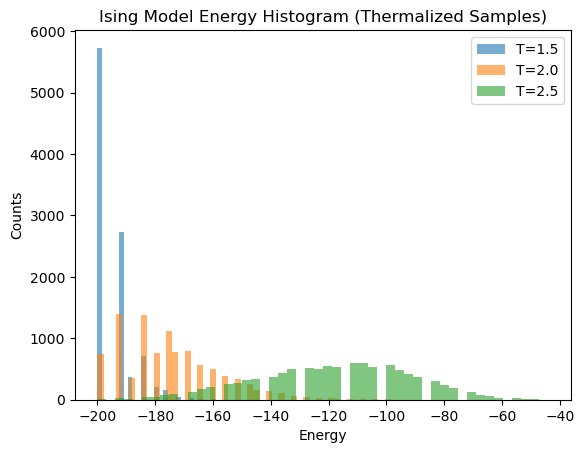

In [9]:
import matplotlib.pyplot as plt
for idx, T in enumerate(kT):
    plt.hist(E[idx], bins=50, alpha=0.6, label=f"T={T}")
plt.xlabel('Energy')
plt.ylabel('Counts')
plt.title('Ising Model Energy Histogram (Thermalized Samples)')
plt.legend()
plt.show()


In [10]:
def mhr_partition_function(kT, E, fe, kT_new):
    """
    Estimate (relative) partition function at kT_new using MHR.
    """
    nrun = len(kT)
    N = [len(e) for e in E]
    Z = 0.0
    for n in range(nrun):
        for i in range(N[n]):
            E_ni = E[n][i]
            num = np.exp(-E_ni/kT_new - fe[n])
            denom = 0.0
            for m in range(nrun):
                denom += N[m] * np.exp(-E_ni/kT[m] + fe[m])
            Z += num / denom
    return Z

Sampling energies at T=1.5 ...
Sampling energies at T=2.0 ...
Sampling energies at T=2.5 ...
Estimating partition function Z(T) with MHR...


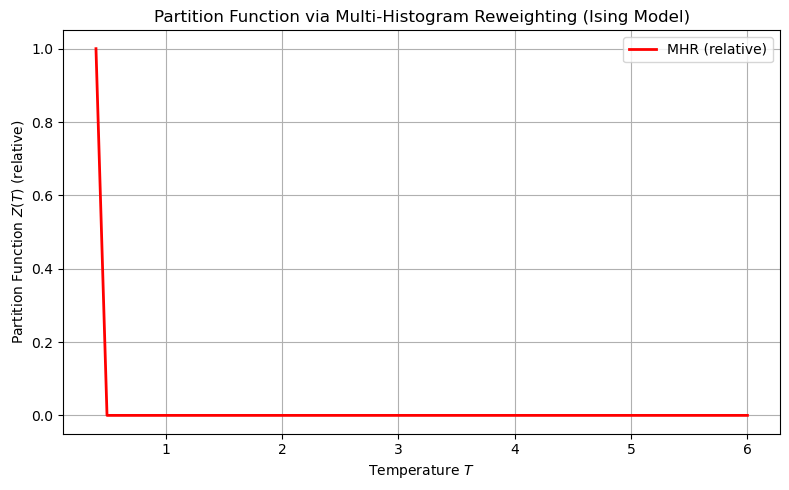

In [11]:
N = 10                      # lattice size (N x N)
kT = np.array([1.5, 2.0, 2.5])  # simulation temperatures
nsamples = 5000                 # samples per temp (can increase for smoother results)
therm_steps = 5000              # thermalization sweeps
sample_gap = 10                 # MC sweeps between samples
latt = RandomL(N)            # initial random lattice
# Step 1: Generate energies for each temperature
E = []
for T in kT:
    print(f"Sampling energies at T={T} ...")
    energies = metropolis_energy_samples(N, T, latt, nsamples=nsamples, therm_steps=therm_steps, sample_gap=sample_gap)
    E.append(energies)

# Step 2: MHR preparation (make b and X)
b = np.array([[-1.0/T] for T in kT])
X = [energies[:, np.newaxis] for energies in E]

# Step 3: Compute relative free energies for MHR
fe = free_energies(b, X)

# Step 4: Estimate partition function at many temperatures
Te = np.linspace(0.4, 6.0, 60) # range to evaluate Z(T)
Z_mhr = []
print("Estimating partition function Z(T) with MHR...")
for T in Te:
    Z_mhr.append(mhr_partition_function(kT, E, fe, T))
Z_mhr = np.array(Z_mhr)

# Step 5: Plot results
plt.figure(figsize=(8,5))
plt.plot(Te, Z_mhr/np.max(Z_mhr), 'r-', lw=2, label="MHR (relative)")
plt.xlabel("Temperature $T$")
plt.ylabel("Partition Function $Z(T)$ (relative)")
plt.title("Partition Function via Multi-Histogram Reweighting (Ising Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Enumerating all 33,554,432 configurations for N=5 ...


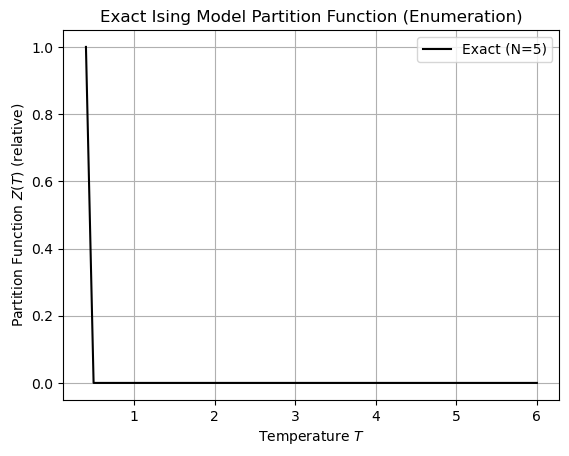

In [13]:

import matplotlib.pyplot as plt

N = 5  
Te = np.linspace(0.4, 6.0, 60)
Z_exact = []
print(f"Enumerating all {2**(N*N):,} configurations for N={N} ...")
for T in Te:
    Z_exact.append(enumerate_partition_function(N, T, latt))
Z_exact = np.array(Z_exact)


plt.plot(Te, Z_exact/np.max(Z_exact), 'k-', label=f'Exact (N={N})')
plt.xlabel('Temperature $T$')
plt.ylabel('Partition Function $Z(T)$ (relative)')
plt.legend()
plt.grid()
plt.title("Exact Ising Model Partition Function (Enumeration)")
plt.show()



In [14]:
print(Z_exact)

[2.75918521e+44 2.29713159e+37 3.63145974e+32 1.23020050e+29
 2.91585401e+26 2.56666214e+24 5.70725138e+22 2.50194323e+21
 1.83026915e+20 1.98907728e+19 2.95397838e+18 5.63689776e+17
 1.31948822e+17 3.65628154e+16 1.16647303e+16 4.19136223e+15
 1.66654259e+15 7.22834497e+14 3.38004878e+14 1.68751569e+14
 8.92256650e+13 4.96231404e+13 2.88615002e+13 1.74683043e+13
 1.09557116e+13 7.09416128e+12 4.72775453e+12 3.23371276e+12
 2.26458682e+12 1.62028917e+12 1.18221169e+12 8.78158824e+11
 6.63104381e+11 5.08331323e+11 3.95142102e+11 3.11127938e+11
 2.47906419e+11 1.99721017e+11 1.62557417e+11 1.33575903e+11
 1.10740623e+11 9.25736473e+10 7.79893964e+10 6.61816402e+10
 5.65453690e+10 4.86221121e+10 4.20612268e+10 3.65921917e+10
 3.20045728e+10 2.81333949e+10 2.48483613e+10 2.20458394e+10
 1.96428529e+10 1.75725412e+10 1.57807037e+10 1.42231491e+10
 1.28636483e+10 1.16723443e+10 1.06245078e+10 9.69955825e+09]


In [15]:
print(latt)

[[ 1  1  1 -1  1 -1 -1 -1  1  1]
 [ 1  1  1  1  1  1  1 -1  1  1]
 [ 1  1  1  1  1  1  1 -1  1  1]
 [ 1  1  1  1  1  1  1 -1  1  1]
 [ 1 -1  1  1  1  1  1 -1  1  1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 1  1 -1 -1 -1 -1 -1 -1 -1  1]
 [ 1  1 -1 -1 -1 -1 -1 -1 -1  1]]
